# Coronagraph inpainting model

## Data downloading and preprocessing

!python3 data.py

In [1]:
from utils import get_default_device
device = get_default_device()
print(device)

cuda


In [2]:
import torch
torch.cuda.empty_cache()

## Creating dataset

In [3]:
batch_size = 2

In [4]:
from torch.utils.data import random_split, DataLoader
from utils import DeviceDataLoader
from data import CoronagraphDataset

dataset = CoronagraphDataset('c3')
# 0.8 - 0.2
train_len = round(0.8*len(dataset))
val_len = len(dataset) - train_len

#random split
train_ds, val_ds = random_split(dataset, [train_len, val_len])

train_dl = DeviceDataLoader(DataLoader(train_ds, batch_size, True, num_workers = 4, pin_memory=True), device)
val_dl = DeviceDataLoader(DataLoader(val_ds, batch_size, True, num_workers = 4, pin_memory=True), device)

/usr/lib/python3/dist-packages/paramiko/transport.py:237: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [ ]:
from model import UNetArchitecture, UNetArchitectureDeluxe, SmallUNet
from utils import to_device
from loss import NewInpaintingLoss, UNetLoss, OldInpaintingLoss

# model = to_device(SingleLayer('c3', InpaintingLoss([6,6, 0.05, 10, 10]), (7,5,3)), device)

# model = to_device(UNetArchitecture('c3_UNet', UNetLoss([4, 6, 0.05, 110, 120])), device)

model = to_device(SmallUNet('c3_Small_Unet', NewInpaintingLoss([6, 6, 0.05, 120, 120]), 2), device)

1. c3_Small_Unet_0.pt


In [ ]:
import torch
from utils import to_device
sample_tensor = (torch.randn(1,1,1024,1024), torch.ones(1,1,1024,1024))
sample_tensor = to_device(sample_tensor, device)

Validation - Epoch: 0: 100%|██████████| 165/165 [00:24<00:00,  6.70it/s]


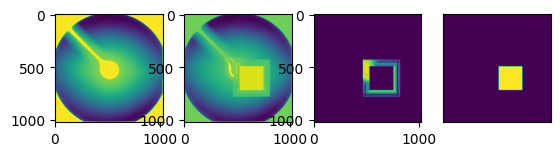

Validation - Epoch: 1: 100%|██████████| 165/165 [00:24<00:00,  6.86it/s]


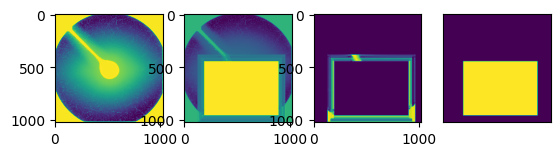

Validation - Epoch: 2: 100%|██████████| 165/165 [00:24<00:00,  6.84it/s]


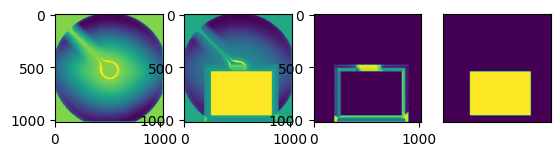

Validation - Epoch: 3: 100%|██████████| 165/165 [00:24<00:00,  6.83it/s]


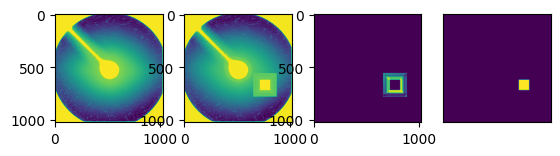

Validation - Epoch: 4: 100%|██████████| 165/165 [00:22<00:00,  7.39it/s]


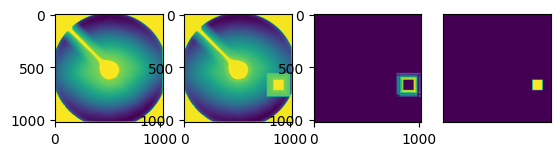

Validation - Epoch: 5: 100%|██████████| 165/165 [00:22<00:00,  7.30it/s]


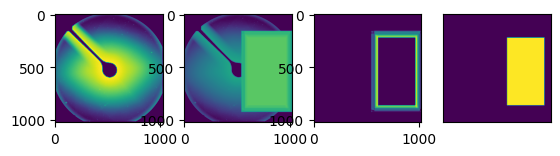

Validation - Epoch: 6: 100%|██████████| 165/165 [00:22<00:00,  7.23it/s]


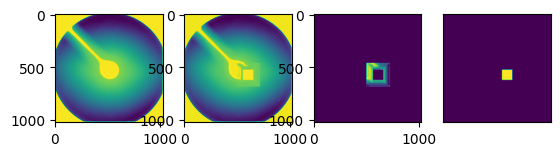

Validation - Epoch: 7: 100%|██████████| 165/165 [00:22<00:00,  7.34it/s]


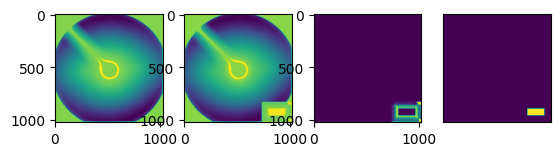

Validation - Epoch: 8: 100%|██████████| 165/165 [00:22<00:00,  7.37it/s]


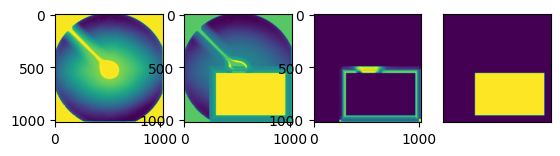

Validation - Epoch: 9: 100%|██████████| 165/165 [00:22<00:00,  7.32it/s]


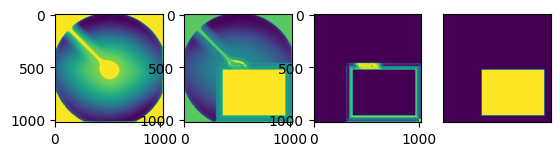

Training - Epoch: 10:  93%|█████████▎| 615/658 [02:49<00:11,  3.63it/s]


KeyboardInterrupt: 

In [ ]:
from torch.optim.lr_scheduler import OneCycleLR
from torch.optim import Adam, SGD, RMSprop

model.fit(
    train_dl,
    val_dl,
    epochs = 150,
    lr = 2e-4,
    batch_size = batch_size,
    weight_decay = 0,
    grad_clip = 1e-3,
    opt_func = Adam,
    lr_sched = None,
    saving_div = 15,
    graph = True,
    sample_input = sample_tensor
)